In [203]:
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

mt5.initialize()
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 10, 31)
timeframe = mt5.TIMEFRAME_H1

# 1) Choose your FX assets
assets = [
    "AUDCHF",
    # "GBPUSD",
]

# assumes: mt5.initialize() already done,
# and you already defined: timeframe, start_date, end_date

returns_list = []

for asset in assets:
    rates = mt5.copy_rates_range(asset, timeframe, start_date, end_date)
    if rates is None or len(rates) == 0:
        raise RuntimeError(f"No data returned for {asset}")

    df = pd.DataFrame(rates)

    # convert MT5 time to datetime index
    df["time_dt"] = pd.to_datetime(df["time"], unit="s")
    df = df.set_index("time_dt")

    # log returns on close prices
    log_ret = np.log(df["close"]).diff().dropna()
    log_ret.name = asset  # so it becomes the column name

    returns_list.append(log_ret)

# 2) Align on common timestamps across all assets
#    (inner join on the index)
returns_df = pd.concat(returns_list, axis=1, join="inner").dropna()

# 3) Build X: T x N matrix of returns
X = returns_df.values  # shape (T, N)

print("returns_df.shape =", returns_df.shape)
print("X.shape =", X.shape)
print("columns (assets) =", returns_df.columns.tolist())

returns_df.shape = (17617, 1)
X.shape = (17617, 1)
columns (assets) = ['AUDCHF']


In [204]:
df = df[["close"]]
df["log_return"] = df["close"].apply(np.log).diff()
df = df.dropna()

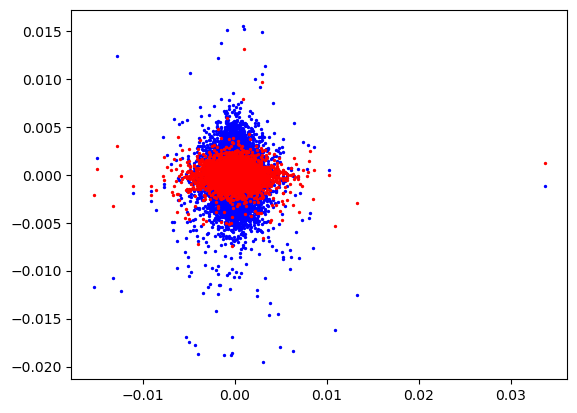

In [205]:
fig, ax = plt.subplots()

ax.scatter(df["log_return"].shift(-1),
           df["close"] - df["close"].ewm(halflife=12).mean(),
           s=2,
           c="blue")

ax.scatter(df["log_return"].shift(-1),
           df["close"] - df["close"].ewm(halflife=2).mean(),
           s=2,
           c="red")

In [67]:
from metalib.indicators import ols_tval_nb

ols_tval = df["close"].rolling(24*5).apply(ols_tval_nb, engine="numba", raw=True)
df["ols_tval"] = ols_tval

<Axes: >

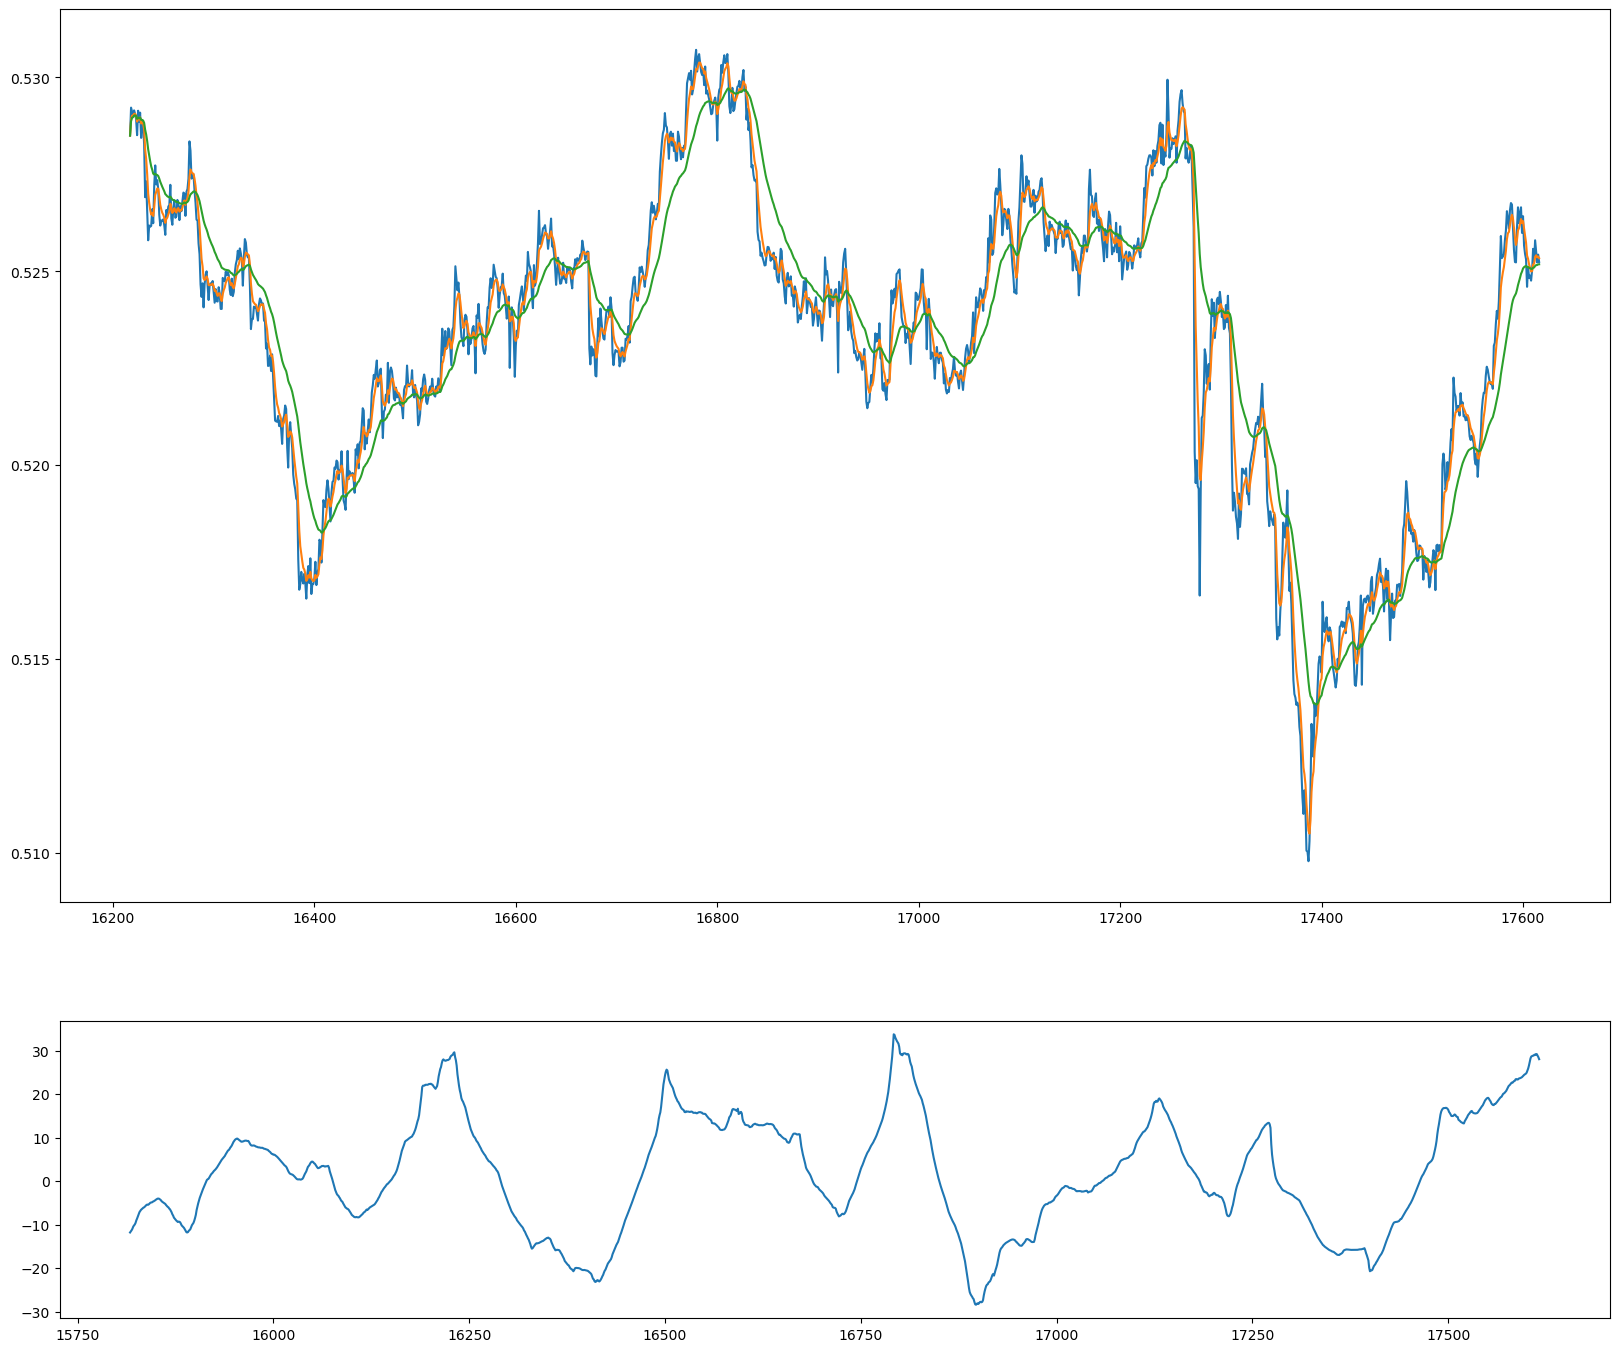

In [69]:
fig, ax = plt.subplots(nrows=2, height_ratios=[1.5, .5])
fig.set_size_inches(20, 17)

df = df.reset_index(drop=True)

df["close"].tail(1400).plot(ax=ax[0])
df["close"].tail(1400).ewm(halflife=2).mean().plot(ax=ax[0])
df["close"].tail(1400).ewm(halflife=12).mean().plot(ax=ax[0])

df["ols_tval"].tail(1800).plot(ax=ax[1])


In [223]:
from itertools import combinations

def _build_features(log_close: pd.Series) -> pd.DataFrame:
    """
    Build z-score features from log-close prices.

    For each rolling window w:
      - continuous z-score: z_w = (log_close - SMA_w) / STD_w
      - binary tail indicators: 1(z_w > threshold) for each threshold

    Cross-scale diffs: z_w1 - z_w2 for every pair w1 < w2.
    """
    features = {}

    z_scores = {}
    for w in rolling_windows:
        sma = log_close.diff().rolling(w).mean()
        std = log_close.diff().rolling(w).std()
        z = (log_close.diff() - sma) / std
        z_scores[w] = z

        features[f"z_{w}"] = z
        features[f"ols_{w}"] = log_close.diff().rolling(w).apply(ols_tval_nb, engine="numba", raw=True)
        features[f"std_{w}"] = log_close.diff().rolling(w).std()

        for th in thresholds:
            features[f"z_{w}_gt_{th}"] = (z > th).astype(float)


    # Cross-scale diffs
    for w1, w2 in combinations(sorted(rolling_windows), 2):
        features[f"z_diff_{w1}_{w2}"] = z_scores[w1] - z_scores[w2]

    return pd.DataFrame(features, index=log_close.index)

In [225]:
log_close = df["close"].apply(np.log)

horizons = [24]
train_ratio = 0.75
hidden_layers = 5
max_iter = 1000
rolling_windows=(12, 24, 5*24)
thresholds=(-3.0, -1.5, 1.5, 3.0)

In [226]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [232]:
feat_df = _build_features(log_close)
targets = {}
for h in horizons:
    targets[h] = log_close.shift(-h) - log_close

# Align: drop any row where features or any target is NaN
valid = feat_df.notna().all(axis=1)
for h in horizons:
    valid &= targets[h].notna()
feat_df = feat_df.loc[valid]
for h in horizons:
    targets[h] = targets[h].loc[valid]

feature_cols_ = list(feat_df.columns)

# Time-series split
split_idx = int(len(feat_df) * train_ratio)
X_train = feat_df.iloc[:split_idx].values
X_val = feat_df.iloc[split_idx:].values

# Fit scaler on training set
scaler_ = StandardScaler()
X_train_scaled = X_train
X_val_scaled = X_val

# Train one MLP per horizon
mlp_models_ = {}
for h in horizons:
    y_train = targets[h].iloc[:split_idx].values
    y_val = targets[h].iloc[split_idx:].values

    mlp = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        max_iter=max_iter,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,
    )
    mlp.fit(X_train_scaled, y_train)
    mlp_models_[h] = mlp

In [233]:
mlp

MLPRegressor(early_stopping=True, hidden_layer_sizes=5, max_iter=1000,
             random_state=42, validation_fraction=0.15)

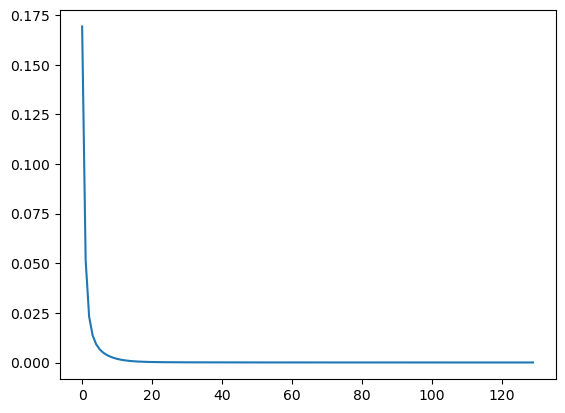

In [234]:

plt.plot(mlp.loss_curve_)

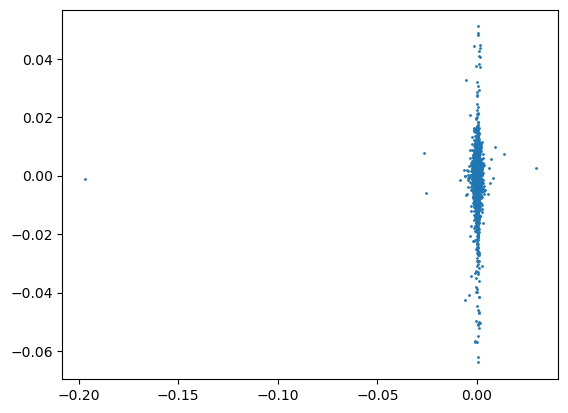

In [235]:
plt.scatter(mlp.predict(X_val_scaled), y_val, s=1)

In [240]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [239]:
confusion_matrix(mlp.predict(X_val_scaled) > 0, y_val > 0)

array([[ 846,  768],
       [1333, 1422]], dtype=int64)

In [241]:
accuracy_score(mlp.predict(X_val_scaled) > 0, y_val > 0)

0.5191119249256123

<Axes: >

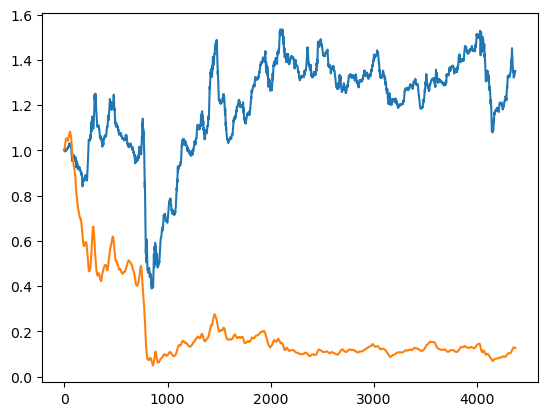

In [252]:
pd.Series(np.cumsum(y_val * np.where(mlp.predict(X_val_scaled)>0, 1, -1))).apply(np.exp).plot()
pd.Series(np.cumsum(y_val)).apply(np.exp).plot()

In [250]:
np.where(mlp.predict(X_val_scaled)>0, 1, -1)

array([ 1, -1, -1, ..., -1,  1,  1])